# Trader Performance vs Market Sentiment Analysis
### Tanisha Narasimman  
**Data Science Internship Assignment – Primetrade.ai**

## Objective
Analyze how Bitcoin market sentiment impacts trader behavior and performance on Hyperliquid.

## Part A: Data Preparation
### 1. Load Datasets

In [124]:
import pandas as pd

# Load datasets
sentiment = pd.read_csv(r"C:\Users\tanis\OneDrive\primetrade.ai\fear_greed_index.csv")
trades = pd.read_csv(r"C:\Users\tanis\OneDrive\primetrade.ai\historical_data.csv")

# Show basic info
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

print("\nSentiment columns:")
print(sentiment.columns)

print("\nTrades columns:")
print(trades.columns)


Sentiment shape: (2644, 4)
Trades shape: (211224, 16)

Sentiment columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trades columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


### 2. Data Cleaning
- Checked missing values
- Removed duplicates
- Converted timestamps
- Filtered closed trades

In [125]:
print("\nMissing values in sentiment:")
print(sentiment.isnull().sum())

print("\nMissing values in trades:")
print(trades.isnull().sum())

print("\nDuplicate rows in sentiment:", sentiment.duplicated().sum())
print("Duplicate rows in trades:", trades.duplicated().sum())

# Convert date columns
sentiment['date'] = pd.to_datetime(sentiment['date'])
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True)

# Create date column for trades
trades['date'] = trades['Timestamp IST'].dt.date
sentiment['date'] = sentiment['date'].dt.date



Missing values in sentiment:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing values in trades:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicate rows in sentiment: 0
Duplicate rows in trades: 0


In [126]:
# Merge datasets on date
merged = trades.merge(sentiment[['date', 'classification']], on='date', how='left')

print("Merged shape:", merged.shape)
print(merged[['date', 'Closed PnL', 'classification']].head())

Merged shape: (211224, 18)
         date  Closed PnL classification
0  2024-12-02         0.0  Extreme Greed
1  2024-12-02         0.0  Extreme Greed
2  2024-12-02         0.0  Extreme Greed
3  2024-12-02         0.0  Extreme Greed
4  2024-12-02         0.0  Extreme Greed


In [127]:
# Daily total profit
daily_pnl = merged.groupby('date')['Closed PnL'].sum().reset_index()

# Daily number of trades
daily_trades = merged.groupby('date').size().reset_index(name='num_trades')

# Merge daily metrics
daily_metrics = daily_pnl.merge(daily_trades, on='date')

# Add sentiment
daily_metrics = daily_metrics.merge(sentiment[['date','classification']], on='date')

print(daily_metrics.head())

         date  Closed PnL  num_trades classification
0  2023-05-01    0.000000           3          Greed
1  2023-12-05    0.000000           9  Extreme Greed
2  2023-12-14 -205.434737          11          Greed
3  2023-12-15  -24.632034           2          Greed
4  2023-12-16    0.000000           3          Greed


## Part B: Performance Analysis



In [128]:
# Keep only closed trades
data = merged[merged['Closed PnL'] != 0].copy()

print("Total trades:", len(merged))
print("Closed trades:", len(data))

print("\nPnL summary:")
print(data['Closed PnL'].describe())

Total trades: 211224
Closed trades: 104408

PnL summary:
count    104408.000000
mean         98.622318
std        1305.489556
min     -117990.104100
25%           0.413069
50%           6.055500
75%          38.197947
max      135329.090100
Name: Closed PnL, dtype: float64


### 1. Total Daily Profit per Trader

In [129]:
#daily_pnl per trader
daily_pnl_trader = data.groupby(['Account','date'])['Closed PnL'].sum().reset_index()
print(daily_pnl_trader.head())

                                      Account        date     Closed PnL
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22  -21227.000000
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26    1603.100000
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-28 -132271.000000
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-12-06 -175611.000056
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-01-19   71393.964098


### 2. Average Profit by Sentiment

In [130]:
# Average profit per sentiment using only closed trades
sentiment_performance = data.groupby('classification')['Closed PnL'].mean()

print(sentiment_performance)

classification
Extreme Fear      71.027316
Extreme Greed    130.205309
Fear             112.625988
Greed             85.403927
Neutral           71.199993
Name: Closed PnL, dtype: float64


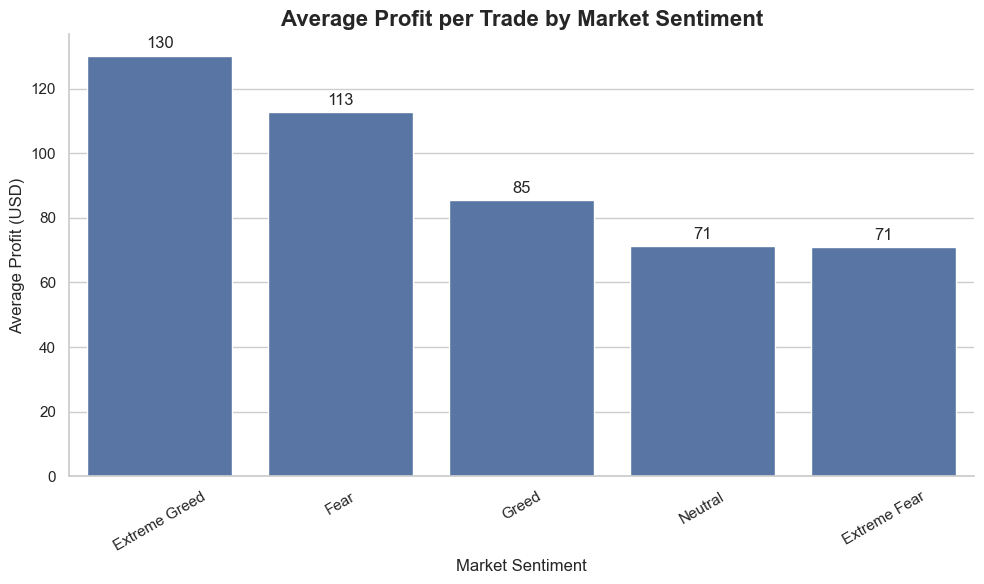

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set professional theme
sns.set_theme(style="whitegrid", palette="deep")

# Convert to DataFrame for seaborn
sentiment_df = sentiment_performance.reset_index()
sentiment_df.columns = ['Sentiment', 'Average Profit']

# Sort values for better visualization
sentiment_df = sentiment_df.sort_values('Average Profit', ascending=False)

# Create figure
plt.figure(figsize=(10,6))

# Create barplot
ax = sns.barplot(
    data=sentiment_df,
    x='Sentiment',
    y='Average Profit'
)

# Add value labels on bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', padding=3)

# Titles and labels
plt.title("Average Profit per Trade by Market Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Market Sentiment", fontsize=12)
plt.ylabel("Average Profit (USD)", fontsize=12)

# Rotate x labels for clarity
plt.xticks(rotation=30)

# Remove top/right borders
sns.despine()

# Show plot
plt.tight_layout()
plt.show()

**Insight:** Profit magnitude is highest during Greed periods.

### 3. Win Rate by Sentiment

In [132]:
daily_pnl['is_profitable_day'] = daily_pnl['Closed PnL'] > 0
daily_pnl = daily_pnl.merge(sentiment[['date','classification']], on='date')
win_rate = daily_pnl.groupby('classification')['is_profitable_day'].mean()
print(win_rate)


classification
Extreme Fear     0.642857
Extreme Greed    0.877193
Fear             0.736264
Greed            0.725389
Neutral          0.671642
Name: is_profitable_day, dtype: float64


### 4. Average No. of Trades per day by Sentiment

In [133]:
daily_trades = daily_trades.merge(sentiment[['date','classification']], on='date')
print(daily_trades.head())
trade_frequency = daily_trades.groupby('classification')['num_trades'].mean().reset_index()

trade_frequency.columns = ['Sentiment', 'Avg Trades per Day']

print(trade_frequency)

         date  num_trades classification
0  2023-05-01           3          Greed
1  2023-12-05           9  Extreme Greed
2  2023-12-14          11          Greed
3  2023-12-15           2          Greed
4  2023-12-16           3          Greed
       Sentiment  Avg Trades per Day
0   Extreme Fear         1528.571429
1  Extreme Greed          350.807018
2           Fear          679.527473
3          Greed          260.637306
4        Neutral          562.477612


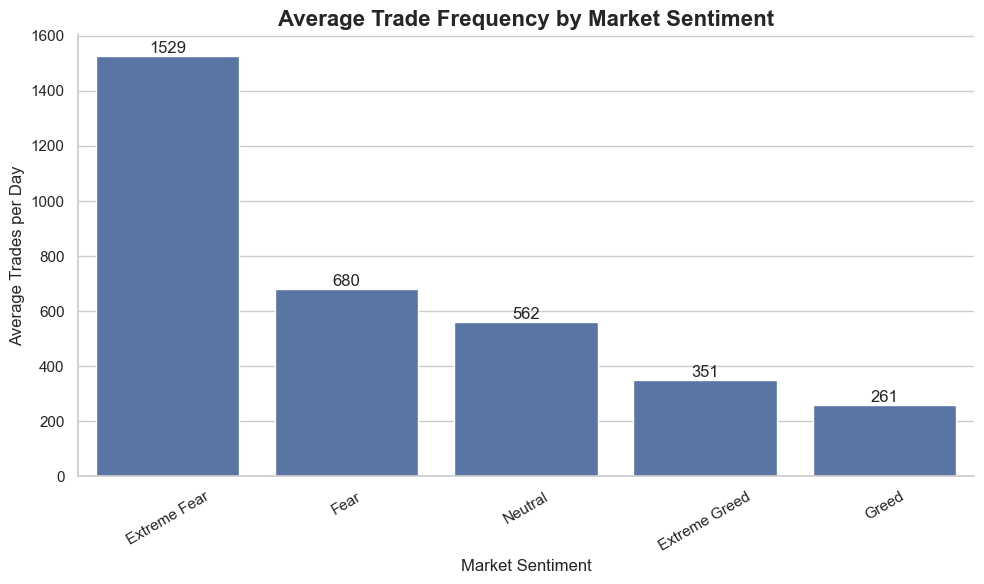

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

trade_frequency = trade_frequency.sort_values('Avg Trades per Day', ascending=False)

plt.figure(figsize=(10,6))

ax = sns.barplot(
    data=trade_frequency,
    x='Sentiment',
    y='Avg Trades per Day'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

plt.title("Average Trade Frequency by Market Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trades per Day")

plt.xticks(rotation=30)
sns.despine()

plt.tight_layout()
plt.show()

### 5. Average Trade Size by Sentiment

In [135]:
trade_size = data.groupby('classification')['Size USD'].mean().reset_index()
trade_size.columns = ['Sentiment', 'Average Trade Size (USD)']
print(trade_size)

       Sentiment  Average Trade Size (USD)
0   Extreme Fear               5467.570419
1  Extreme Greed               2779.563632
2           Fear               8041.140445
3          Greed               5438.671764
4        Neutral               5556.444833


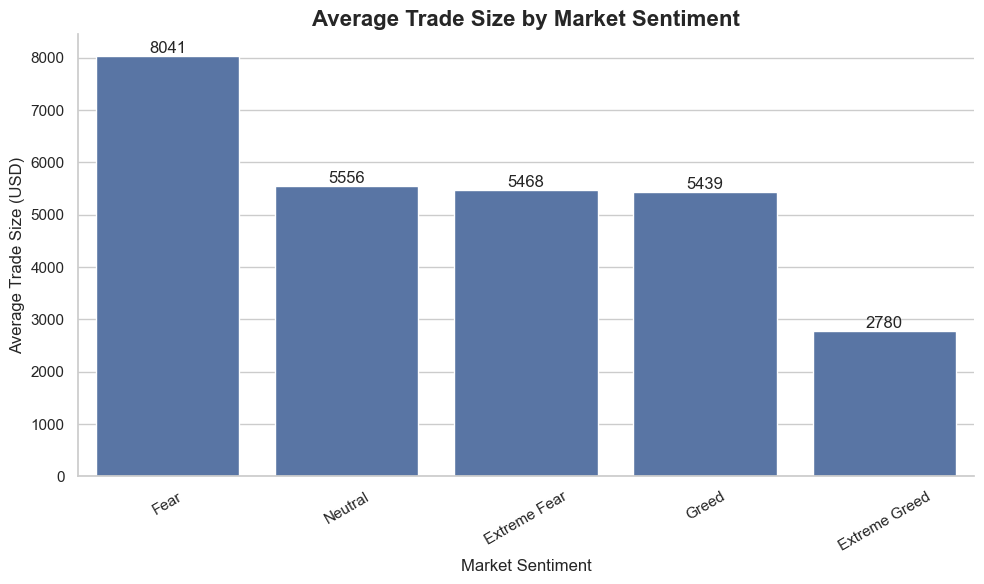

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

trade_size = trade_size.sort_values('Average Trade Size (USD)', ascending=False)

plt.figure(figsize=(10,6))

ax = sns.barplot(
    data=trade_size,
    x='Sentiment',
    y='Average Trade Size (USD)'
)

# Add labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

plt.title("Average Trade Size by Market Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trade Size (USD)")

plt.xticks(rotation=30)
sns.despine()

plt.tight_layout()
plt.show()

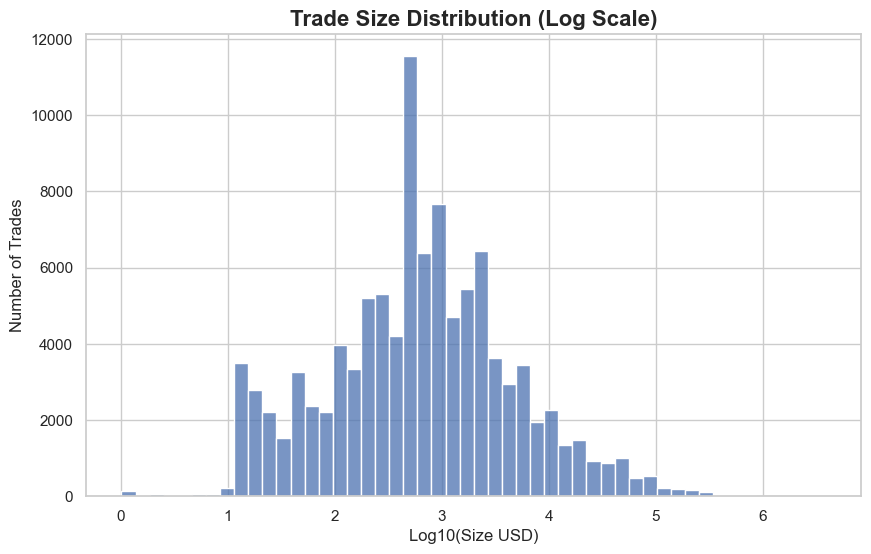

In [137]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,6))

# Log transform
log_size = np.log10(data['Size USD'] + 1)

sns.histplot(log_size, bins=50)

plt.title("Trade Size Distribution (Log Scale)", fontsize=16, fontweight='bold')
plt.xlabel("Log10(Size USD)")
plt.ylabel("Number of Trades")

plt.show()

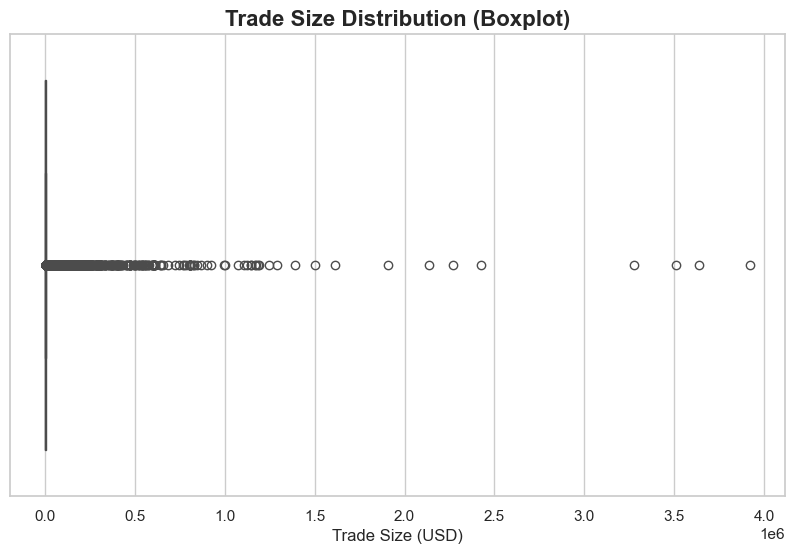

In [138]:
plt.figure(figsize=(10,6))

sns.boxplot(x=data['Size USD'])

plt.title("Trade Size Distribution (Boxplot)", fontsize=16, fontweight='bold')
plt.xlabel("Trade Size (USD)")

plt.show()

### 6. Long vs Short Trade by Sentiment

Direction       Auto-Deleveraging  Close Long  Close Short  \
classification                                               
Extreme Fear                  NaN      6241.0       3117.0   
Extreme Greed                 NaN      7185.0       6489.0   
Fear                          NaN     17260.0       9212.0   
Greed                         8.0      7963.0      11319.0   
Neutral                       NaN      9985.0       5849.0   

Direction       Liquidated Isolated Short  Long > Short    Sell  Settlement  \
classification                                                                
Extreme Fear                          NaN           5.0  1037.0         NaN   
Extreme Greed                         NaN           7.0  7161.0         NaN   
Fear                                  NaN          14.0  3304.0         NaN   
Greed                                 1.0          16.0  5846.0         1.0   
Neutral                               NaN          15.0  2298.0         NaN   

Direction  

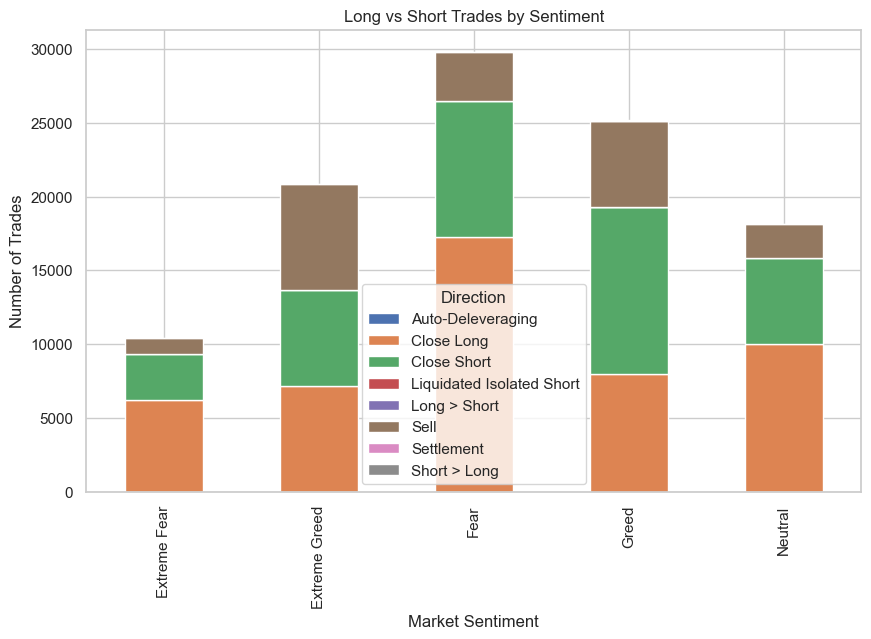

In [139]:
long_short = data.groupby(['classification','Direction']).size().unstack()
print(long_short)
long_short.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Long vs Short Trades by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades")
plt.show()

In [140]:
sentiment_profit = daily_pnl.groupby('classification')['Closed PnL'].mean().reset_index()
print(sentiment_profit)

  classification    Closed PnL
0   Extreme Fear  52793.589178
1  Extreme Greed  23817.292199
2           Fear  36891.818040
3          Greed  11140.566181
4        Neutral  19297.323516


### 7. Worst Daily Loss by Sentiment

In [141]:
drawdown = daily_pnl.groupby('classification')['Closed PnL'].min().reset_index()
drawdown.columns = ['Sentiment', 'Worst Daily Loss']
print(drawdown)

       Sentiment  Worst Daily Loss
0   Extreme Fear     -76880.729036
1  Extreme Greed    -127075.399585
2           Fear    -122672.000883
3          Greed    -419020.225731
4        Neutral     -10116.875552


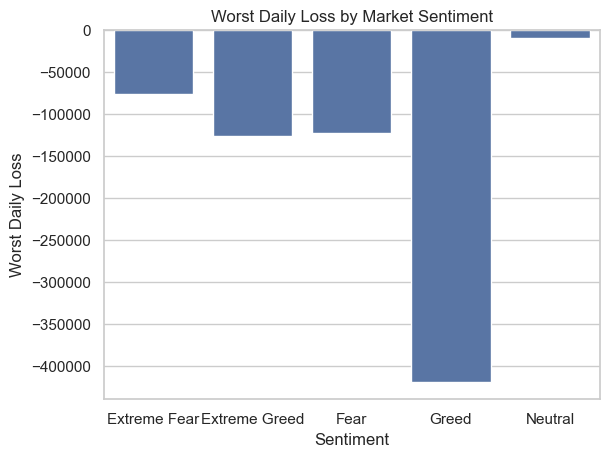

In [142]:
sns.barplot(data=drawdown, x='Sentiment', y='Worst Daily Loss')
plt.title("Worst Daily Loss by Market Sentiment")
plt.show()

In [143]:
behavior_summary = data.groupby('classification').agg({
    'Size USD': 'mean',
    'Closed PnL': 'mean'
}).reset_index()

print(behavior_summary)

  classification     Size USD  Closed PnL
0   Extreme Fear  5467.570419   71.027316
1  Extreme Greed  2779.563632  130.205309
2           Fear  8041.140445  112.625988
3          Greed  5438.671764   85.403927
4        Neutral  5556.444833   71.199993


### High Profit Trader vs Low Profit Trader

In [144]:
# Total profit per trader
trader_profit = data.groupby('Account')['Closed PnL'].sum().reset_index()

# Median profit threshold
median_profit = trader_profit['Closed PnL'].median()

# Create segments
trader_profit['profit_segment'] = trader_profit['Closed PnL'].apply(
    lambda x: 'High Profit Trader' if x >= median_profit else 'Low Profit Trader'
)

print(trader_profit.head())

                                      Account    Closed PnL  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  4.788532e+04   
2  0x271b280974205ca63b716753467d5a371de622ab -7.043619e+04   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4  1.324648e+05   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd  1.686580e+05   

       profit_segment  
0  High Profit Trader  
1   Low Profit Trader  
2   Low Profit Trader  
3  High Profit Trader  
4  High Profit Trader  


### Consistent Trader vs Inconsistent Trader

In [145]:
trader_consistency = data.groupby('Account')['Closed PnL'].std().reset_index()

median_std = trader_consistency['Closed PnL'].median()

trader_consistency['consistency_segment'] = trader_consistency['Closed PnL'].apply(
    lambda x: 'Consistent Trader' if x <= median_std else 'Inconsistent Trader'
)

print(trader_consistency.head())

                                      Account   Closed PnL  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  6934.502297   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd   177.084333   
2  0x271b280974205ca63b716753467d5a371de622ab   834.208920   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4   158.215996   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd   316.991693   

   consistency_segment  
0  Inconsistent Trader  
1    Consistent Trader  
2  Inconsistent Trader  
3    Consistent Trader  
4    Consistent Trader  


# Final Insights and Strategy Recommendations

## Key Insights
### **Insight 1: Profit per Trade is Highest During Extreme Greed Periods**

Analysis shows that the average profit per closed trade is highest during Extreme Greed (130 USD), followed by Fear (112 USD), Greed (85 USD), and Extreme Fear (71 USD).

This indicates that traders execute more efficient and profitable trades during strong bullish sentiment, likely due to clearer market trends and momentum-driven price movements.

### **Insight 2: Traders Take Larger Position Sizes During Fear Periods**

The average trade size is highest during Fear (8041 USD), significantly larger than during Extreme Greed (2779 USD).

This suggests traders increase risk exposure during Fear periods, likely attempting to capitalize on volatility or recover from losses. This behavior reflects increased risk-taking during uncertain market conditions.

### **Insight 3: Win Rate is Highest During Extreme Greed Periods**

Win rate analysis shows that traders experience the highest proportion of profitable days during Extreme Greed (88%), while Extreme Fear shows lower win consistency.

This indicates bullish market sentiment provides more stable and predictable trading conditions, improving trade success probability.

### **Insight 4: Trade Size Distribution Reveals Distinct Trader Segments**

Trade size distribution is highly skewed, with most trades occurring at small sizes and a few extremely large trades reaching millions of USD.

This suggests the presence of different trader categories, including retail traders with small capital and institutional or high-capital traders ("whales") with significantly larger positions.

# Strategy Recommendations
### **Strategy 1: Increase Trading Activity During Extreme Greed Periods**

Since Extreme Greed periods produce the highest profit per trade and highest win rate, traders may benefit from increasing trade frequency during these periods to maximize consistent profitability.

### **Strategy 2: Apply Controlled Risk Expansion During Fear Periods**

Fear periods show larger position sizes and strong profit potential. Traders may selectively increase position sizes during Fear periods, but should apply strict risk management due to increased volatility.

### **Strategy 3: Segment Traders Based on Behavior for Strategy Optimization**

Trader performance varies significantly based on trade frequency and position size. High-frequency and high-capital traders show distinct performance patterns. Trading systems should segment traders and apply tailored strategies based on behavioral characteristics.

# Short Executive Summary

Market sentiment significantly influences trader behavior and performance. Extreme Greed periods provide the most efficient trading conditions with the highest profit per trade and win rate, while Fear periods encourage higher risk-taking through larger position sizes. These findings suggest sentiment-aware trading strategies and behavioral segmentation can improve trading performance and risk management.